In [1]:
import numpy as np
from functions import *
import matplotlib.pylab as plt
from mnist import load_mnist

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


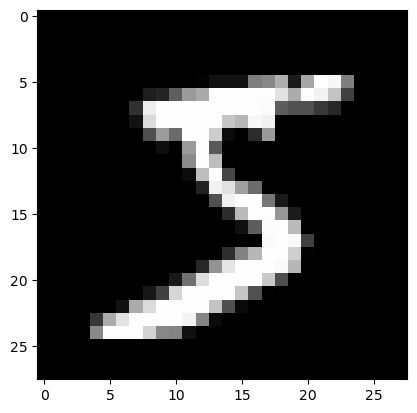

In [3]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)   # 데이터 읽기
img = x_train[0].reshape(28, 28)
label = t_train[0]
print(label) 

plt.imshow(img, cmap='gray')
plt.show()

In [9]:
class Net_Cls:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size+1, hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size+1, output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        
        b = [1] if x.ndim==1 else np.ones((x.shape[0], 1))
        
        x = np.append(b, x, axis=x.ndim-1) # bias 추가
        a1 = np.dot(x, W1)
        z1 = np.append(b, sigmoid(a1), axis=x.ndim-1) 
        a2 = np.dot(z1, W2)
        y = softmax(a2)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy        

    
    def gradient(self, x, t):
        # 기존 gradient랑 동일함(input -> output과정을 먼저 구하기 위해서 순전파를 구함)
        W1, W2 = self.params['W1'], self.params['W2']
        
        b = [1] if x.ndim==1 else np.ones((x.shape[0],1))
        
        grads = {}
        
        a1 = np.dot(np.append(b, x, axis=x.ndim-1), W1)
        z1 = sigmoid(a1)
        a2 = np.dot(np.append(b, z1, axis=x.ndim-1), W2)
        y = softmax(a2) #delta(2)

        
        # 역전파 계산
        dy = y-t
        c = np.dot(dy, W2.T) #delta(2) W(2)^T
        c = c[1:] if x.ndim==1 else c[:, 1:] #-> bias 뗴기
        dz1 = z1*(1-z1)*c # element by element로 그냥 곱셈
        #델타(1) =  h'(a) * c
        
        grads['W2'] = np.dot(np.append(b, z1, axis=x.ndim-1).T, dy)/x.shape[0]
        grads['W1'] = np.dot(np.append(b, x, axis=x.ndim-1).T, dz1)/x.shape[0]
        
        return grads        

In [11]:
network = Net_Cls(input_size=784, hidden_size=100, output_size=10) # output_size = 0 ~ 9까지 10개

epoch = 40
train_size = x_train.shape[0] # 60000개
bch_size = 100   # 미니배치 크기
eta = 0.1

iter_per_epoch = max(int(train_size/bch_size), 1) # 1에폭당 600개의 배치

train_loss_list = []
train_acc_list = []
test_acc_list = []

for j in range(epoch):
    bch_idx = np.random.permutation(train_size).reshape((iter_per_epoch, bch_size)) # 배치 고르는 것
    for idx in bch_idx:
        grad = network.gradient(x_train[idx], t_train[idx])    # 기울기 계산(이전에는 numerical이었다면 지금은 오차역전파 사용한 gradient사용)
        
        network.params['W1'] -= eta * grad['W1']
        network.params['W2'] -= eta * grad['W2']
        
        loss = network.loss(x_train[idx], t_train[idx])
        train_loss_list.append(loss)
        
    train_acc = network.accuracy(x_train, t_train)
    test_acc = network.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print("[Epoch %2d/%2d] Train acc %3.4f , Test acc %3.4f "%(j, epoch, train_acc, test_acc))        

[Epoch  0/40] Train acc 0.8141 , Test acc 0.8198 
[Epoch  1/40] Train acc 0.8842 , Test acc 0.8881 
[Epoch  2/40] Train acc 0.9005 , Test acc 0.9022 
[Epoch  3/40] Train acc 0.9081 , Test acc 0.9125 
[Epoch  4/40] Train acc 0.9135 , Test acc 0.9149 
[Epoch  5/40] Train acc 0.9186 , Test acc 0.9214 
[Epoch  6/40] Train acc 0.9219 , Test acc 0.9244 
[Epoch  7/40] Train acc 0.9254 , Test acc 0.9272 
[Epoch  8/40] Train acc 0.9276 , Test acc 0.9297 
[Epoch  9/40] Train acc 0.9318 , Test acc 0.9322 
[Epoch 10/40] Train acc 0.9342 , Test acc 0.9342 
[Epoch 11/40] Train acc 0.9369 , Test acc 0.9365 
[Epoch 12/40] Train acc 0.9388 , Test acc 0.9373 
[Epoch 13/40] Train acc 0.9409 , Test acc 0.9392 
[Epoch 14/40] Train acc 0.9438 , Test acc 0.9414 
[Epoch 15/40] Train acc 0.9449 , Test acc 0.9436 
[Epoch 16/40] Train acc 0.9473 , Test acc 0.9450 
[Epoch 17/40] Train acc 0.9484 , Test acc 0.9471 
[Epoch 18/40] Train acc 0.9504 , Test acc 0.9478 
[Epoch 19/40] Train acc 0.9516 , Test acc 0.9483 


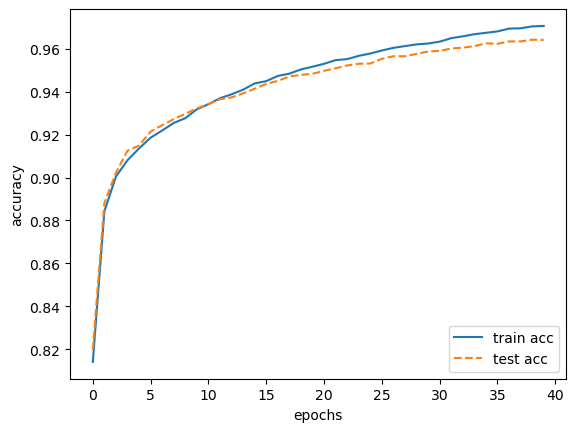

In [13]:
# 정확도 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc='lower right')
plt.show()

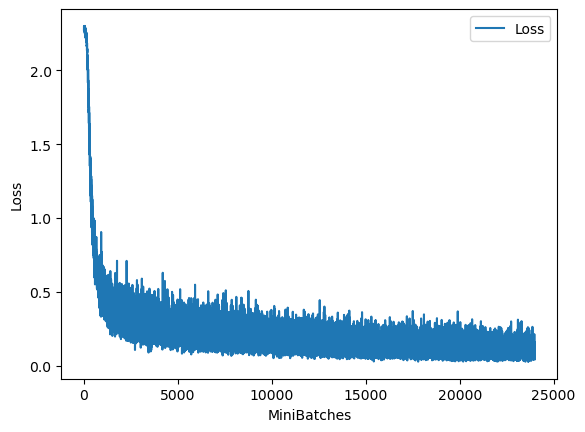

In [15]:
# 손실함수 그래프 그리기
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='Loss')
plt.xlabel("MiniBatches")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.show()